In [1]:
%load_ext autoreload
%autoreload 2


In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

from typing import List, Dict, Any, Callable
from pathlib import Path
import seaborn as sns


# local imports
from src.data_processing.preprocessing.pandas_preprocessors import flatten_dataframe
from src.data_processing.model_analyzers.elastic_net_analyzers.elastic_net_analyzer import MetricAnalyzer, FeatureImportanceAnalyzer, ExperimentMetadata
from src.data_processing.model_analyzers.elastic_net_analyzers.path_finder import PathFinder

# Dopamine Only


da_only_path = '/projects/p31961/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg'
da_experimenter = XGBRegExperimenter(da_only_path, analyzer=XGBRegAnalyzer, results = XGBRegrResults)
da_experimenter.run_experiment(
    number_of_runs=20, cls_to_drop=['mouse_id', 'day'])

da_w_day_experimenter = XGBRegExperimenter(
    da_only_path, analyzer=XGBRegAnalyzer, results=XGBRegrResults)
da_w_day_experimenter.run_experiment(
    number_of_runs=20, cls_to_drop=['mouse_id'])

# analyzer.fit_best_xgb_model()
# analyzer.plot_model_results()
# 

In [8]:
# def analyze_and_plot_results(path:str):d
# da_path = '/projects//ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/xgb_regression_da_only_hyperopt_elastic_net'
da_path = '/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_normalzied_tune'
path_to_save_figs = Path("/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/gaby_collab/endpoint_experiment_figures")
path = Path(da_path)
path_finder = PathFinder(path)
path_finder.feature_importance_paths

[PosixPath('results/experiments/endpoint_experiments/xgb_regression_da_normalzied_tune/with_day_experiment_results/feature_importance_results.parquet'),
 PosixPath('results/experiments/endpoint_experiments/xgb_regression_da_normalzied_tune/without_day_experiment_results/feature_importance_results.parquet')]

# Feature Importance from baseline model with day

AttributeError: Rectangle.set() got an unexpected keyword argument 'legend'

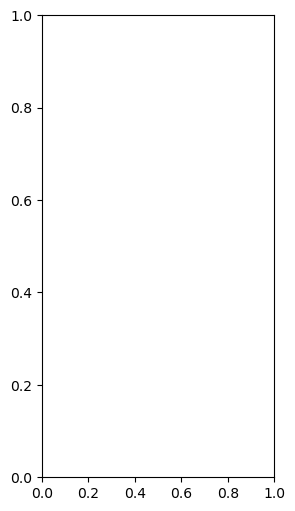

In [9]:

feautre_path_with_day = path_finder.feature_importance_paths[1]
feature_analyzer = FeatureImportanceAnalyzer(
    feautre_path_with_day, ExperimentMetadata, path_to_save_figs=path_to_save_figs)
feature_analyzer.read_and_clean_data()
feature_analyzer.plot_data(save = False)

# Training and testing metrics

In [5]:
with_day = MetricAnalyzer(path_finder.metrics_paths[0], ExperimentMetadata)
no_day = MetricAnalyzer(path_finder.metrics_paths[1], ExperimentMetadata)
with_day.read_and_clean_data()
no_day.read_and_clean_data()
with_day.data_frame

,dataset,data_cat,with_day,is_net,metric,value
0,Train,metrics,False,True,Mean Squared Error,0.073740
1,Dev,metrics,False,True,Mean Squared Error,0.143851
2,Test,metrics,False,True,Mean Squared Error,0.087546
3,Train,metrics,False,True,Mean Squared Error,0.084633
4,Dev,metrics,False,True,Mean Squared Error,0.039085
...,...,...,...,...,...,...
265,Dev,metrics,False,True,R2 Score,-0.055336
266,Test,metrics,False,True,R2 Score,-0.218751
267,Train,metrics,False,True,R2 Score,0.089851
268,Dev,metrics,False,True,R2 Score,-0.121544


In [6]:
def create_all_metrics(with_day:MetricAnalyzer, no_day:MetricAnalyzer):
    all_metrics = (pd
                   .concat([with_day.data_frame, no_day.data_frame])
                   .reset_index(drop=True)
                   .assign(with_day = lambda df_: df_['with_day'].map({True: 'day', False: 'no_day'}))
                   .query("dataset!='Dev' & metric!='R2 Score'")
    )
    return all_metrics
all_metrics = create_all_metrics(with_day, no_day)
all_metrics

,dataset,data_cat,with_day,is_net,metric,value
0,Train,metrics,no_day,True,Mean Squared Error,0.073740
2,Test,metrics,no_day,True,Mean Squared Error,0.087546
3,Train,metrics,no_day,True,Mean Squared Error,0.084633
5,Test,metrics,no_day,True,Mean Squared Error,0.090676
6,Train,metrics,no_day,True,Mean Squared Error,0.078870
...,...,...,...,...,...,...
443,Test,metrics,day,True,Mean Absolute Error,0.281229
444,Train,metrics,day,True,Mean Absolute Error,0.235148
446,Test,metrics,day,True,Mean Absolute Error,0.123265
447,Train,metrics,day,True,Mean Absolute Error,0.221306


/Users/mds8301/anaconda3/envs/enigma_xgb/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/mds8301/anaconda3/envs/enigma_xgb/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.75}` instead.

  func(*plot_args, **plot_kwargs)
/Users/mds8301/anaconda3/envs/enigma_xgb/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.75}` instead.

  func(*plot_args, **plot_kwargs)


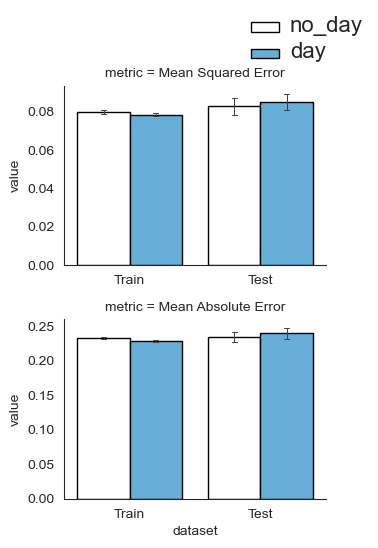

In [13]:
sns.set_style("white")

facet = sns.FacetGrid(all_metrics, row = "metric", sharey=False, sharex = False, height = 2.5, aspect = 1).map(
    sns.barplot,
    'dataset',
    'value',
    data=all_metrics,
    hue='with_day',
    palette=['white', '#56B4E9'],
    # width=.8,
    dodge=True,
    edgecolor='black',
    estimator='mean',
    errorbar='se',
    capsize=.08,
    errwidth=.75)
facet.add_legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Get the legend from the figure
legend = facet.fig.legends[0]

# Increase the size of the legend
plt.setp(legend.get_texts(), fontsize='16')  # for legend text
plt.setp(legend.get_title(), fontsize='18')  # for legend title

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(path_to_save_figs / "all_metrics.svg", format='svg', dpi=1200)

# Hyperparamters


In [ ]:
params_path = '/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/xgb_regression_da_only_hyperopt_elastic_net/params.yaml'
with open(params_path) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

params = (pd.DataFrame
          .from_dict(params['best_params'], orient = 'index')
          .reset_index()
          .assign(Hyper_Parameter = lambda df_: df_['index'].str.replace('_', ' ').str.title())
          .rename(columns={'Hyper_Parameter': 'Hyper Parameter',
                           0: 'Value'})
          .assign(Value  =  lambda df_: df_.Value)
          .drop(columns=['index'])
          [['Hyper Parameter', 'Value']]

)
params.to_csv(path_to_save_figs / "hyper_parameters.csv", index = False)
params.to_html(path_to_save_figs / "hyper_parameters.html", index = False)